In [1]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("example") \
    .getOrCreate()

# Differences

Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called 'YARD_SIZE', and then see if the new feature is correlated with our outcome variable.

In [2]:
df = spark.read.csv("dataset/2017_StPaul_MN_Real_Estate.csv", header=True)
df = df.withColumn('ACRES', df.ACRES.cast('double'))
df = df.withColumn('SalesClosePrice', df.SalesClosePrice.cast('double'))
df = df.withColumn('FOUNDATIONSIZE', df.FOUNDATIONSIZE.cast('double'))
df = df.withColumn('LISTPRICE', df.LISTPRICE.cast('double'))
df = df.withColumn('AssessedValuation', df.AssessedValuation.cast('double'))
df = df.withColumn('Taxes', df.Taxes.cast('double'))
df = df.withColumn('Bedrooms', df.Bedrooms.cast('double'))
df = df.withColumn('BATHSTOTAL', df.BATHSTOTAL.cast('double'))
df = df.withColumn('SQFTBELOWGROUND', df.SQFTBELOWGROUND.cast('double'))
df = df.withColumn('SQFTABOVEGROUND', df.SQFTABOVEGROUND.cast('double'))

# Import needed functions
from pyspark.sql.functions import to_date, dayofweek, to_timestamp,col
df = df.withColumn("LISTDATE", to_timestamp("LISTDATE", 'M/d/yyyy H:mm'))
sorted(df.columns)

['ACRES',
 'APPLIANCES',
 'ASSESSMENTPENDING',
 'AssessedValuation',
 'AssociationFee',
 'AssumableMortgage',
 'BASEMENT',
 'BATHDESC',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BathsFull',
 'BathsHalf',
 'Bedrooms',
 'City',
 'Class',
 'CoolingDescription',
 'DAYSONMARKET',
 'DiningRoomDescription',
 'EXTERIOR',
 'FENCE',
 'FOUNDATIONSIZE',
 'Fireplaces',
 'GarageDescription',
 'LISTDATE',
 'LISTPRICE',
 'LISTTYPE',
 'LivingArea',
 'LotSizeDimensions',
 'MLSID',
 'MapLetter',
 'No.',
 'OriginalListPrice',
 'PDOM',
 'PoolDescription',
 'PostalCode',
 'PotentialShortSale',
 'PricePerTSFT',
 'ROOF',
 'ROOMFAMILYCHAR',
 'RoomArea1',
 'RoomArea2',
 'RoomArea3',
 'RoomArea4',
 'RoomArea5',
 'RoomArea6',
 'RoomArea7',
 'RoomArea8',
 'RoomFloor1',
 'RoomFloor2',
 'RoomFloor3',
 'RoomFloor4',
 'RoomFloor5',
 'RoomFloor6',
 'RoomFloor7',
 'RoomFloor8',
 'SQFTABOVEGROUND',
 'SQFTBELOWGROUND',
 'STREETNAME',
 'STYLE',
 'SalesClosePrice',
 'SchoolDistrictNumber',
 'StateOrProvince',
 

In [3]:
df.show(3)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+-------------------+---------+---------------+-----------------+------------+--------------+-----+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------

In [4]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SalesClosePrice')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SalesClosePrice')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('LOT_SIZE_SQFT', 'SalesClosePrice')))

Corr of ACRES vs SALESCLOSEPRICE: 0.20714585430854263
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664401
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.22060612588935338


# Ratios

Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

In [5]:
# ASSESSED_TO_LIST
df = df.withColumn("ASSESSED_TO_LIST", df.AssessedValuation/df.LISTPRICE)
df[['AssessedValuation', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn("TAX_TO_LIST", df.Taxes/df.LISTPRICE)
df[['TAX_TO_LIST', 'Taxes', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn("BED_TO_BATHS", df.Bedrooms/df.BATHSTOTAL)
df[['BED_TO_BATHS', 'Bedrooms', 'BATHSTOTAL']].show(5)

+-----------------+---------+----------------+
|AssessedValuation|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0| 139900.0|             0.0|
|              0.0| 210000.0|             0.0|
|              0.0| 225000.0|             0.0|
|              0.0| 230000.0|             0.0|
|              0.0| 239900.0|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+------+---------+
|         TAX_TO_LIST| Taxes|LISTPRICE|
+--------------------+------+---------+
|0.013280914939242315|1858.0| 139900.0|
| 0.00780952380952381|1640.0| 210000.0|
|0.010622222222222222|2390.0| 225000.0|
|0.009330434782608695|2146.0| 230000.0|
|0.008378491037932471|2010.0| 239900.0|
+--------------------+------+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|Bedrooms|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|     3.0|       2.0|
|1.

# Deeper Features

In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



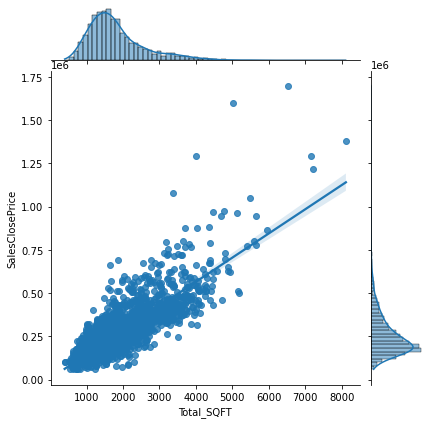

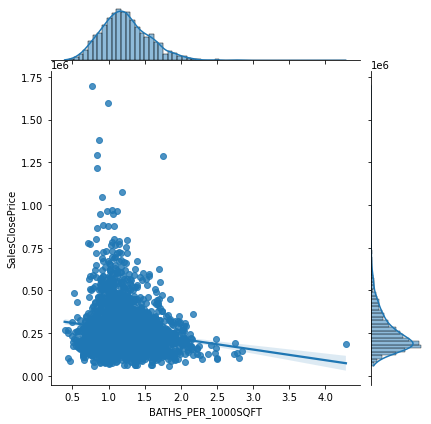

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()

# Time Components

Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

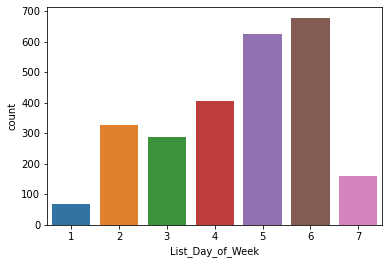

In [7]:
# Convert to date type
df = df.withColumn('LISTDATE', to_date('LISTDATE'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

# Joining On Time Components

Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

In [8]:
# from pyspark.sql.functions import year

# # Initialize dataframes
# df = real_estate_df
# price_df = median_prices_df

# # Create year column
# df = df.withColumn('list_year', year('LISTDATE'))

# # Adjust year to match
# df = df.withColumn('report_year', (df['list_year'] - 1))

# # Create join condition
# condition = [df['CITY'] == price_df['City'], df['report_year'] == price_df['Year']]

# # Join the dataframes together
# df = df.join(price_df, on=condition, how='left')
# # Inspect that new columns are available
# df[['MedianHomeValue']].show()

# Date Math

In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a window(). window() allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

In [9]:
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

# Cast data type
mort_df = df.withColumn('DATE', to_date('LISTDATE'))

# Create window
w = Window().orderBy('DATE')
# Create lag column
mort_df = mort_df.withColumn('DATE-1', lag('DATE', 1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))
# Print results
mort_df.show()

+----+-----+-------------------+--------------------+------------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+--------------------+---------+-----------------+--------------------+------------+--------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+---

# Extracting Text to New Features

Garages are an important consideration for houses in Minnesota where most people own a car and the snow is annoying to clear off a car parked outside. The type of garage is also important, can you get to your car without braving the cold or not? Let's look at creating a feature

In [10]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached%Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached%Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+------------------------------------------------------------------+-------------------+
|                                                 GARAGEDESCRIPTION|has_attached_garage|
+------------------------------------------------------------------+-------------------+
|                                                   Attached Garage|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                               Attached Garage, Driveway - Asphalt|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|                    

# Splitting & Exploding

Being able to take a compound field like GARAGEDESCRIPTION and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

In [11]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split('GARAGEDESCRIPTION', ','))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode('garage_list'))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+-----------------------------+
|               ex_garage_list|
+-----------------------------+
|       On-Street Parking Only|
|              Attached Garage|
|        Contract Pkg Required|
|                      Covered|
|       On-Street Parking Only|
|                         None|
|                    Tuckunder|
|                      Carport|
| More Parking Offsite for Fee|
|  More Parking Onsite for Fee|
|                        Other|
|            Driveway - Shared|
|           Garage Door Opener|
|  More Parking Onsite for Fee|
|            Driveway - Gravel|
|           Driveway - Asphalt|
|                Heated Garage|
|            Driveway - Gravel|
|        Valet Parking for Fee|
|               Uncovered/Open|
|                Heated Garage|
|    No Int Access to Dwelling|
|           Garage Door Opener|
|           Underground Garage|
|                        Other|
|                   Units Vary|
|                   Unassigned|
|        Valet Parking for Fee|
|       

# Pivot & Join

Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

In [12]:
from pyspark.sql.functions import lit,col
from pyspark.sql.types import IntegerType
ex_df = ex_df.withColumn('constant_val', lit(1))
ex_df = ex_df.withColumnRenamed('No.','NO')
ex_df = ex_df.withColumn('NO', col('NO').cast(IntegerType()))
df = df.withColumnRenamed('No.','NO')
df = df.withColumn('NO', col('NO').cast(IntegerType()))

ex_df.show(2)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+----------+---------+---------------+-----------------+------------+--------------+-----+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+--------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+------------

In [13]:
from pyspark.sql.functions import coalesce, first

# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

# Binarizing Day of Week

Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called List_Day_of_Week that has Monday is labeled 1.0 and Sunday is 7.0. Let's convert this to a binary field with weekday being 0 and weekend being 1. We can use the pyspark feature transformer Binarizer to do this.

In [15]:
# Import transformer
from pyspark.ml.feature import Binarizer
from pyspark.sql.types import DoubleType

df = df.withColumn('List_Day_of_Week', col('List_Day_of_Week').cast(DoubleType()))
# Create the transformer
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week' , 'Listed_On_Weekend']].show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             7.0|              1.0|
|             2.0|              0.0|
|             2.0|              0.0|
|             6.0|              1.0|
|             3.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             5.0|              0.0|
|             7.0|              1.0|
|             6.0|              1.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             2.0|              0.0|
|             5.0|              0.0|
|             1.0|              0.0|
|             1.0|              0.0|
|             6.0|              1.0|
|             7.0|              1.0|
|             6.0|              1.0|
+----------------+-----------------+
only showing top 20 rows



# Bucketing

If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

In [23]:
sample_df = df.select('Bedrooms').sample(withReplacement=False, fraction=0.5,seed=42).toPandas()
sample_df['Bedrooms'].dtypes

dtype('float64')

c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


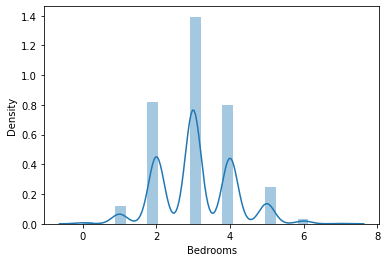

+--------+--------+
|Bedrooms|bedrooms|
+--------+--------+
|     3.0|     3.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
+--------+--------+
only showing top 20 rows



In [24]:
from pyspark.ml.feature import Bucketizer

# Plot distribution of sample_df
sns.distplot(sample_df, axlabel='Bedrooms')
plt.show()

# Create the bucket splits and bucketizer
splits = [0,1, 2, 3, 4, 5,  float('Inf')]
buck = Bucketizer(splits=splits, inputCol='Bedrooms', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['Bedrooms', 'bedrooms']].show()

# One Hot Encoding

In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in SCHOOLDISTRICTNUMBER they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert SCHOOLDISTRICTNUMBER from a categorial variable into a numeric vector to use in our machine learning model later.

In [26]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SchoolDistrictNumber', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SchoolDistrictNumber', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SchoolDistrictNumber|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]